In [1]:
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai import *
from fastai.data_block import _maybe_squeeze
from efficientnet_pytorch import EfficientNet

In [3]:
path = Path('/home/jupyter/rsns/data')
df_train = pd.read_csv(path/'train_fastai_format.csv')

In [6]:
df_train.tail()

,fn,labels
674252,ID_f737f4cc1.png,NaN
674253,ID_4c92d70b5.png,NaN
674254,ID_a9797cb3a.png,NaN
674255,ID_9375f67bd.png,NaN
674256,ID_5c8b5d701.png,intraparenchymal subarachnoid subdural any


In [44]:
df_train['PatientID'] = df_train['fn'].apply(lambda x: x.split('.')[0])
df_train['fn'] = df_train['fn'].apply(lambda x: x.split('.')[0] + '.jpg')
#df_train['fn'][0].split('.')[0]

In [45]:
df_train.tail()

,fn,labels,PatientID
674252,ID_f737f4cc1.jpg,NaN,ID_f737f4cc1
674253,ID_4c92d70b5.jpg,NaN,ID_4c92d70b5
674254,ID_a9797cb3a.jpg,NaN,ID_a9797cb3a
674255,ID_9375f67bd.jpg,NaN,ID_9375f67bd
674256,ID_5c8b5d701.jpg,intraparenchymal subarachnoid subdural any,ID_5c8b5d701


In [47]:
#export
np.random.seed(42)
patients = df_train.PatientID.unique()
pat_mask = np.random.random(len(patients))<0.8
pat_trn = patients[pat_mask]
mask = df_train.PatientID.isin(pat_trn)
df_train['is_valid'] = mask

In [55]:
valid_idx = df_train[df_train['is_valid'] == False]['PatientID'].unique()
valid_idx

array(['ID_2669954a7', 'ID_12cb04d93', 'ID_ca62b5929', 'ID_4419f8ae9', ..., 'ID_8f47f9abd', 'ID_9aedc667e',
       'ID_4c92d70b5', 'ID_5c8b5d701'], dtype=object)

In [52]:
train_idx = df_train[df_train['is_valid'] == True]['PatientID'].unique()
train_idx

array(['ID_63eb1e259', 'ID_52c9913b1', 'ID_4e6ff6126', 'ID_7858edd88', ..., 'ID_6a6cd0773', 'ID_f737f4cc1',
       'ID_a9797cb3a', 'ID_9375f67bd'], dtype=object)

In [62]:
len(valid_idx),len(train_idx)

(134682, 539575)

In [63]:
539575+134682

674257

In [65]:
df_train.tail()

,fn,labels,PatientID,is_valid
674252,ID_f737f4cc1.jpg,NaN,ID_f737f4cc1,True
674253,ID_4c92d70b5.jpg,NaN,ID_4c92d70b5,False
674254,ID_a9797cb3a.jpg,NaN,ID_a9797cb3a,True
674255,ID_9375f67bd.jpg,NaN,ID_9375f67bd,True
674256,ID_5c8b5d701.jpg,intraparenchymal subarachnoid subdural any,ID_5c8b5d701,False


In [66]:
df_train.to_csv('/home/jupyter/rsns/data/preprocessed/train_seed42.csv',index=False)

In [12]:
# Radek's monkey patch to work out NAN in pandas
def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)

In [13]:
ItemList.label_from_df = modified_label_from_df
df_test = pd.read_csv(path/'raw/stage_1_sample_submission.csv')
df_test['fn'] = df_test['ID'].apply(lambda x: '_'.join(x.split('_')[0:2]) + '.png')
test_fns = df_test['fn'].unique()

In [14]:
tfms = get_transforms(flip_vert=False,  max_warp=0., max_rotate=60., max_zoom=1.1)

In [15]:
bs = 64
sz = 224

In [16]:
data = (ImageList
        .from_csv(path,'train_fastai_format.csv',folder='preprocessed/224/train')
        .split_by_rand_pct(seed=42)
        .label_from_df(label_delim=' ')
        .transform(tfms,size=(sz,sz))
        .add_test(str(path) + '/preprocessed/224/test/' + test_fns)
        .databunch(bs=bs,num_workers=16)
        .normalize(imagenet_stats)
       )

In [9]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6)
#model._fc = nn.Linear(model._fc.in_features,6)

Loaded pretrained weights for efficientnet-b0


In [10]:
learn = Learner(data,model,metrics=[accuracy_thresh],model_dir=path/'models/eff_net').to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 1.32E-03


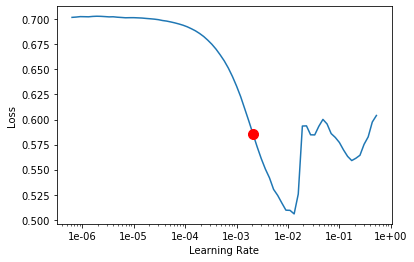

In [11]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [12]:
lr = 1e-3
learn.fit_one_cycle(2,lr)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.099890,0.096031,0.966498,25:03
1,0.084352,0.076741,0.972378,23:35


In [ ]:
learn.save('effb0-baseline-128')

In [11]:
learn.load('effb0-224_9');

# Effb4

In [9]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=6)

Loaded pretrained weights for efficientnet-b4


In [10]:
learn = Learner(data,model,metrics=[accuracy_thresh],model_dir=path/'models/eff_net').to_fp16()

In [11]:
learn.load('effb4-224-pretrained');

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy_thresh,time


In [14]:
from fastai.callbacks import SaveModelCallback,EarlyStoppingCallback

In [15]:
lr = 1e-4
learn.fit_one_cycle(10,lr,callbacks=[EarlyStoppingCallback(learn,min_delta=0.001,patience=3),
                                    SaveModelCallback(learn,every='epoch',name='effb4-224')
                                   ])

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.081337,0.073665,0.973807,1:00:31
1,0.079333,0.072725,0.974042,57:29
2,0.072081,0.072326,0.974291,57:58
3,0.075553,0.071787,0.974433,57:51
4,0.077546,0.070276,0.974964,58:00
5,0.075147,0.069582,0.975171,57:19
6,0.079122,0.069178,0.975163,57:46
7,0.072017,0.068712,0.975464,57:27


KeyboardInterrupt: 

In [13]:
learn.save('effb4-baseline-128')

In [17]:
!ls {path}/models/eff_net

effb4-224_0.pth  effb4-224_4.pth  effb4-baseline-128.pth
effb4-224_1.pth  effb4-224_5.pth  effbo-baseline-128.pth
effb4-224_2.pth  effb4-224_6.pth  tmp.pth
effb4-224_3.pth  effb4-224_7.pth


In [19]:
learn.load('effb4-224_7');

# Prediction

In [12]:
path

PosixPath('/home/jupyter/rsns/data')

In [13]:
sub_name = 'effb0_0979-224'

In [14]:
def make_submission(sub_name):  
    preds, targs = learn.get_preds(DatasetType.Test)
    ids, labels = [], []

    for fn, pred in zip(test_fns, preds):
        for i, label in enumerate(data.train_ds.classes):
            ids.append(f"{fn.split('.')[0]}_{label}")
            pred_prob = '{0:1.10f}'.format(pred[i].item())
            labels.append(pred_prob)

    
    df_test = pd.DataFrame({'ID': ids, 'Label': labels})
    df_test.to_csv(f'{path}/submissions/{sub_name}.csv.zip', compression='zip', index=False)

In [15]:
make_submission(sub_name)

In [16]:
!~/.local/bin/kaggle competitions submit -c rsna-intracranial-hemorrhage-detection -f {path}/submissions/{sub_name}.csv.zip -m {sub_name}

100%|██████████| 3.79M/3.79M [00:04<00:00, 970kB/s]
Successfully submitted to RSNA Intracranial Hemorrhage Detection